# ASTR-513 Project Analysis

### Cosmology Parameters

$$\Omega_m = 0.31,~~
\Omega_l = 0.69,~~
\Omega_b = 0.048$$

$$h = 0.68,~~
\sigma_8 = 0.82,~~
n_s = 0.97,~~
z = 0.701897025$$

## Read in Data

### Imports and Definitions

In [1]:
import gizmo_analysis as gizmo 
import utilities as ut

import numpy as np

from astropy.cosmology import Planck18 as cosmo

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from scipy.stats import binned_statistic_dd
import astropy.units as u
import astropy.cosmology.units as cu
import astropy.constants as c
from astropy.io import fits
from matplotlib.colors import LogNorm, CenteredNorm, TwoSlopeNorm
import pandas as pd
from scipy.interpolate import griddata
from astropy.convolution import Gaussian2DKernel, convolve_fft
import subprocess
from scipy.ndimage import histogram
from skimage.measure import block_reduce
# BP Necessary imports.

In [2]:
redshift = 0.702 * cu.redshift
omega_m = 0.31
omega_l = 0.69
omega_b = 0.048
h = 0.68
sigma_8 = 0.82
n_s = 0.97
# BP Planck cosmological parameters for cosmological simulation.

In [3]:
from astropy.visualization import quantity_support
quantity_support()  
# BP Enable astropy unit support with MPL.

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f43b47e56d0>

### Gizmo Analysis

In [4]:
gizmo.io
# BP Initialize Gizmo.

<module 'gizmo_analysis.gizmo_io' from '/home/baparker/code/gizmo_analysis/gizmo_io.py'>

In [5]:
simulation_directory = '/home/baparker/m12r_res7100/'
part = gizmo.io.Read.read_snapshots('all', 'redshift', 0.702, simulation_directory)
# BP Set simulation directory and read in all particle data at given redshift.


# in utilities.simulation.Snapshot():
* reading:  home/baparker/m12r_res7100/snapshot_times.txt

* input redshift = 0.702:  using snapshot index = 332, redshift = 0.702


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/baparker/m12r_res7100/output/snapdir_332/snapshot_332.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 60327928 particles
    dark2     (id = 2): 6226512 particles
    gas       (id = 0): 58520742 particles
    star      (id = 4): 1820812 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    snapshot_332.0.hdf5
    snapshot_332.1.hdf5
    snapshot_332.2.hdf5
    snapshot_332.3.hdf5

* reading cosmological parameters from:  home/baparker/m12r_res7100/initial_condition/ic_L172_m12r.conf

* checking sanity of particle properties


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host (position, velocity, principal 

In [6]:
x = part['gas']['position'][:, 0]
y = part['gas']['position'][:, 2]
z = part['gas']['position'][:, 1]
# BP Read in gas particle locations

xoffset = 89990.81
yoffset = 89786.91
zoffset = 92491.32
# BP Define center of zoom in region (in kpc).

length = 15039
# BP Define side length of zoom in region (in kpc).

ind = (x < xoffset + length) & (x > xoffset - length) & (y < yoffset + length) & (y > yoffset - length)
# BP Calculate indices of all particles within length of xoffset and zoffset.

x = x[ind] - xoffset
y = y[ind] - yoffset
z = z[ind] - zoffset
# BP Renormalize coordinates about the center.

nH = part['gas'].prop('number.density')[ind]
# BP Define hydrogen number density.

mass_frac = part['gas']['massfraction'][:,0][ind]
# BP Get the mass fraction of gas particles.

temp = part['gas']['temperature'][ind]
# BP Get the temperature of gass partiles.

metallicity_fe = part['gas'].prop('metallicity.fe')[ind]
# BP Get the metallicity [Fe/H] of the gas cells.

cell_size = part['gas']['size'][ind] * u.kpc
# BP Get the linear size of each gas cell.

sfr = part['gas']['sfr'][ind]
# BP Get the star formation rate of each gas cell.

# distance = part['gas'].prop('host.distance.total')[ind]
distance = np.sqrt(x**2 + y**2 + z**2)
# BP Get the linear distance of each gas cell to the center of its host galaxy.

gas_loc_plot = np.vstack((x,y)).T
# BP Create grid of coordinates for plotting and interpolating.

In [7]:
star_x = part['star']['position'][:, 0]
star_y = part['star']['position'][:, 2]
star_z = part['star']['position'][:, 1]

star_xoffset = 89990.81
star_yoffset = 89786.91
star_zoffset = 92491.32
# BP Define center of zoom in region (in kpc).

star_ind = (star_x < star_xoffset + length) & (star_x > star_xoffset - length) & (star_y < star_yoffset + length) & (star_y > star_yoffset - length)
# BP Calculate indices of all particles within length of xoffset and zoffset.

star_x = star_x[star_ind] - star_xoffset
star_y = star_y[star_ind] - star_yoffset
star_z = star_z[star_ind] - star_zoffset
# BP Renormalize coordinates about the center.

star_mass = part['star']['mass'][star_ind]

star_age = part['star'].prop('age')[star_ind]

star_loc_plot = np.vstack((star_x, star_y)).T

## Plots

### Generate Phase Diagram

In [8]:
sort = np.argsort(mass_frac)
nH_plot, temp_plot, mass_frac_plot = nH[sort], temp[sort], mass_frac[sort]
# BP Sort markers by mass_frac for plotting.

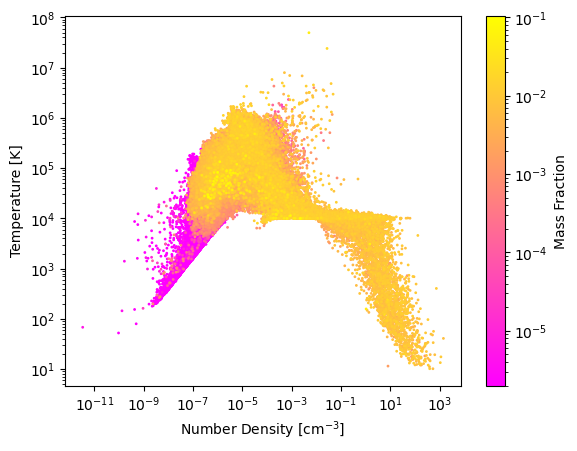

In [9]:
plt.scatter(nH_plot[::100], temp_plot[::100], c=mass_frac_plot[::100], s=1, cmap='spring', norm=LogNorm())
plt.colorbar(label = 'Mass Fraction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number Density [cm$^{{-3}}$]')
plt.ylabel('Temperature [K]')
plt.savefig('Phase_Diagram.png', dpi=500)
# BP Plot phase diagram of gas cells.

## Binned Data

### Hydrogen Density

In [10]:
n = 2100
gridx = np.linspace(x.min(), x.max(), n+1)
gridy = np.linspace(y.min(), y.max(), n+1)
# BP Create grid of x and y locations of bin edges with n bins.

In [11]:
nH_sum, _, _ = binned_statistic_dd(gas_loc_plot, nH, bins=[gridx, gridy], statistic='sum')
# BP Calculate total hydrogen density within each bin. 

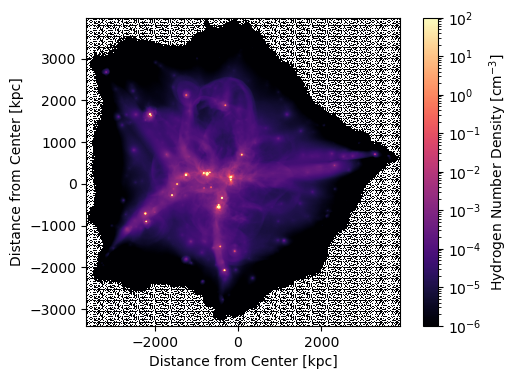

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
plt.imshow(nH_sum, norm = LogNorm(vmin=1e-6, vmax=1e2), cmap = 'magma', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower')#vmin = 1e-8, vmax = 1e-1
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Hydrogen Number Density [cm$^{{-3}}$]')
plt.savefig('Hydrogen_Column_Density_Binned.png', dpi=500)
# BP Plot hydrogen density of the center galaxy.

### Temperature

In [13]:
temp_avg, _, _ = binned_statistic_dd(gas_loc_plot, temp, bins=[gridx, gridy], statistic='mean')
temp_avg = np.nan_to_num(temp_avg, nan=0)
# BP Calculate the average gas temperature within each bin.

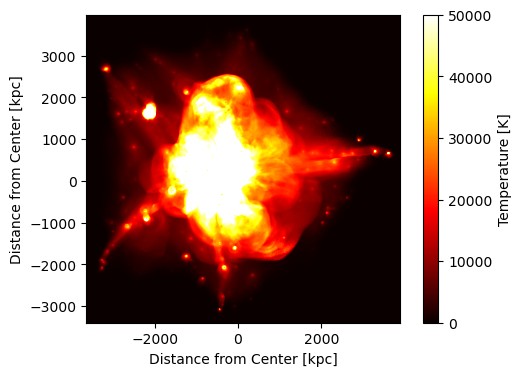

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
plt.imshow(temp_avg, vmin=0, vmax=5e4, cmap = 'hot', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower')
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Temperature [K]')
plt.savefig('Temperature_Binned.png', dpi=500)
# BP Plot average temperature for center galaxy.

## Emissivities

### Generate Cloudy Input File

In [15]:
cloudy_loc = '/home/baparker/code/c23.00/project/'
# BP Location of cloudy directory.

Generate emissivities over a grid of input parameters. Varying density from $10^{-10}$ to $10^{10}~\text{cm}^{-3}$ and temperature from 0.1 to $10^{10}~$K. 

In [16]:
nH_min, nH_max = -10, 10
temp_min, temp_max = -1, 10
step_size = 0.25
# BP Define Cloudy grid start and stop parameters in log space.

In [17]:
text = 'title cloud irradiated by ism background\n\
constant density\n\
hden -10 log vary\n\
grid range from {:.0f} to {:.0f} with {:.2f} dex steps\n\
constant temperature -1 log vary\n\
grid range from {:.0f} to {:.0f} with {:.2f} dex steps\n\
cmb redshift {:.3f}\n\
table hm12 z={:.3f}\n\
no molecules\n\
stop zone 1\n\
set dr 0\n\
Database H-like Lyman pumping off\n\
no induced processes\n\
set save hash "return"\n\
save continuum no hash "Lya.con"\n\
save grid no hash "Lya.grid"\n\
save lines emissivity emergent last "Lya.emissivities"\n\
H  1 1215.67A\n\
end of lines\n\
iterate to convergence'.format(nH_min, nH_max, step_size, temp_min, temp_max, step_size, redshift, redshift)
# BP Create string to pass into cloudy as input parameters.

In [18]:
with open(cloudy_loc + 'Lya.in', 'w') as f:
    f.write(text)
# BP Save string into input file for cloudy.

In [19]:
# p = subprocess.Popen(['/home/baparker/code/c23.00/source/cloudy.exe', '-r', 'Lya'], cwd=cloudy_loc)
# p.wait()
# # BP Run cloudy with saved input file.

### Plot Interpolated Emissivity Table

In [20]:
grid_file = '/home/baparker/code/c23.00/project/Lya.grid'
output_file = '/home/baparker/code/c23.00/project/Lya.emissivities'
# BP Define files for Ly alpha output emissivities and grid locations.

In [21]:
grid = pd.read_csv(grid_file, delimiter = '\t')
grid_dense = np.array(grid['HDEN=%f L'])
grid_temp = np.array(grid['CONSTANT '])
# BP Read in grid parameters from cloudy output files.

In [22]:
output = pd.read_csv(output_file, delimiter = '\t')
grid_lya = np.log10(np.array(output['H  1 1215.67A']))
# BP Read in emissivities from cloudy output file.

In [23]:
den_min, den_max = grid_dense.min(), grid_dense.max()
temp_min, temp_max = grid_temp.min(), grid_temp.max()
xg, yg = np.mgrid[den_min:den_max:1000j, temp_min:temp_max:1000j]
# BP Create grid of points to pass into interpolation scheme.

interp = griddata((grid_dense, grid_temp), grid_lya, (xg, yg), method='cubic')
# BP Calculate rectangular cubic interpolation to get emissivities for any density and temperature Ly alpha cloud.

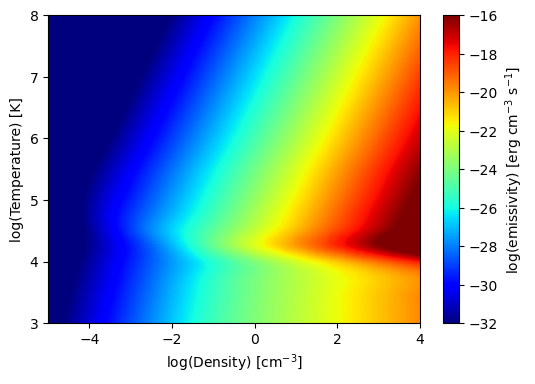

In [24]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(interp.T, vmin=-32, vmax=-16, extent=(den_min, den_max, temp_min, temp_max), cmap = 'jet', aspect='auto', origin='lower')
ax.set_ylabel('log(Temperature) [K]')
ax.set_xlabel(r'log(Density) [cm$^{{-3}}$]')
ax.set_xlim(-5, 4)
ax.set_ylim(3, 8)
plt.colorbar(label = r'log(emissivity) [erg cm$^{{-3}}$ s$^{{-1}}$]')
plt.savefig('Emissivity_Table_Smooth.png', dpi=500)
# BP Plot emissivity values for grid of densities and temperatures.

In [25]:
den_min, den_max = grid_dense.min(), grid_dense.max()
temp_min, temp_max = grid_temp.min(), grid_temp.max()
xg, yg = np.mgrid[den_min:den_max:225j, temp_min:temp_max:125j]

interp = griddata((grid_dense, grid_temp), grid_lya, (xg, yg), method='cubic')
# BP Calculate rough interpolated grid to match with paper.

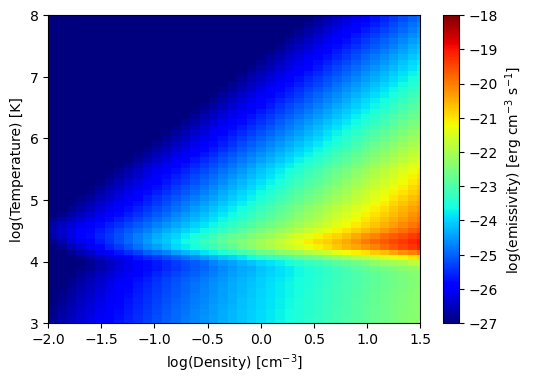

In [26]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(interp.T, vmin=-27, vmax=-18, extent=(den_min, den_max, temp_min, temp_max), cmap = 'jet', aspect='auto', origin='lower')
ax.set_ylabel('log(Temperature) [K]')
ax.set_xlabel(r'log(Density) [cm$^{{-3}}$]')
ax.set_xlim(-2, 1.5)
ax.set_ylim(3, 8)
plt.colorbar(label = r'log(emissivity) [erg cm$^{{-3}}$ s$^{{-1}}$]')
plt.savefig('Emissivity_Table_Compare.png', dpi=500)
# BP Plot rough emissivity table to match with paper.

## Calculate actual emissivities at each gridpoint

### Emissivity from gas

In [27]:
emissivity_log = griddata((grid_dense, grid_temp), grid_lya, (np.log10(nH), np.log10(temp)))
# BP Calculate the emissivity for each gas cell in the zoomed in region.

In [28]:
emissivity_binned, _, _ = binned_statistic_dd(gas_loc_plot, 10**emissivity_log, bins=[gridx, gridy], statistic='sum')
# BP Bin the gas cell emissivity to plot.

In [29]:
emissivity_binned_log = np.log10(emissivity_binned)
emissivity_binned_log[emissivity_binned_log == -np.inf] = -40
# BP Convert to log scale for plotting and replace all infinities.

/tmp/ipykernel_636953/3459541166.py:1: RuntimeWarning: divide by zero encountered in log10
  emissivity_binned_log = np.log10(emissivity_binned)


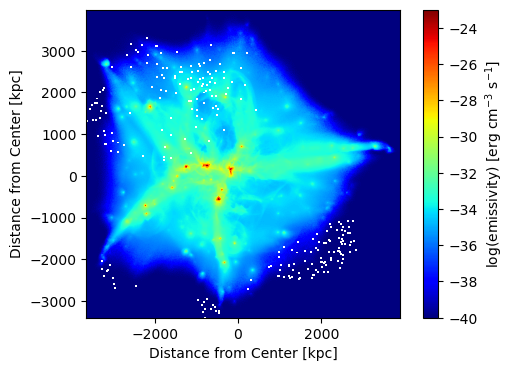

In [30]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(emissivity_binned_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=-40, vmax=-23)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(emissivity) [erg cm$^{{-3}}$ s$^{{-1}}$]')
plt.savefig('Simulated_Emissivity_Gas_Only.png', dpi=500)
# BP Plot emissivity for the entire galaxy.

### Convert to luminosity

In [31]:
emissivity_units = 10**emissivity_log * u.erg / u.cm**3 / u.s

In [32]:
cell_size_cube = cell_size**3
# BP Calculate the size of each gas cell.

luminosity_units = (emissivity_units * cell_size_cube).to(u.erg / u.s)
# BP Calculate luminosity assuming square gas cells.

In [33]:
luminosity_binned, _, _ = binned_statistic_dd(gas_loc_plot, luminosity_units, bins=[gridx, gridy], statistic='sum')
luminosity_binned_log = np.log10(luminosity_binned)
luminosity_binned_log[luminosity_binned_log == -np.inf] = 28
# BP Bin the calculated luminosity for plotting as an image.

/tmp/ipykernel_636953/738478506.py:2: RuntimeWarning: divide by zero encountered in log10
  luminosity_binned_log = np.log10(luminosity_binned)


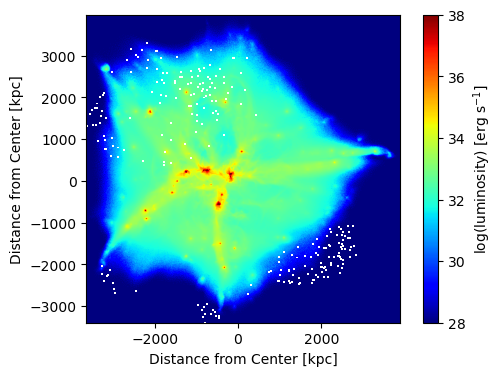

In [34]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_binned_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=28, vmax=38)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [erg s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Gas_Only.png', dpi=500)
# BP Plot luminosity of entire galaxy.

In [35]:
total_ly_alpha = np.sum(luminosity_units)
# BP Calculate total Lyman alpha luminosity

print('The total lyman alpha luminosity is {:.3e}'.format(total_ly_alpha))

The total lyman alpha luminosity is nan erg / s


### Lumionsity from stars

In [36]:
ly_alpha = 1215.67 * u.AA
ly_alpha_red = (1 + redshift) * ly_alpha

In [37]:
sfr_tot = np.sum(sfr)
# BP Calculate total star formation rate of galaxy.

In [38]:
luminosity_continuum = (sfr_tot * c.c * 1e28 / (1.4 * ly_alpha_red.to(u.um)**2)).value * u.erg / u.s
# BP Calculate total continuum contribution from stars according to star formation rate.

In [39]:
star_where = star_mass[star_age < 1e8]
# BP Index some stellar property for stars that are younger than 1e8 years.

In [40]:
star_gridx = np.linspace(star_x.min(), star_x.max(), n+1)
star_gridy = np.linspace(star_y.min(), star_y.max(), n+1)
# BP Create grid to interpolate over for stars.

In [41]:
stellar_field, _, _ = binned_statistic_dd(star_loc_plot, star_where, bins=[star_gridx, star_gridy], statistic='count')
stellar_field = stellar_field/np.sum(stellar_field)
# BP Count how many stars are in each bin, normalize to integrate to 1.
# BP This stellar field will be used to scale the continuum luminosity.

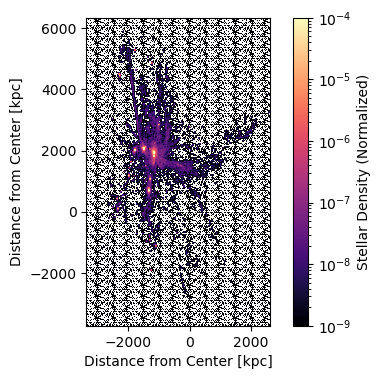

In [42]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(stellar_field, norm=LogNorm(vmin=1e-9, vmax=1e-4), cmap = 'magma', extent = [star_x.min(), star_x.max(), star_y.min(), star_y.max()], origin='lower')
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Stellar Density (Normalized)')
plt.savefig('Stellar_Density_Field.png', dpi=500)
# BP Plot stellar field of galaxy.

In [43]:
luminosity_continuum_field = luminosity_continuum * stellar_field

In [44]:
luminosity_continuum_field_log = np.log10(luminosity_continuum_field.value)
luminosity_continuum_field_log[luminosity_continuum_field_log == -np.inf] = 30

/tmp/ipykernel_636953/3314741800.py:1: RuntimeWarning: divide by zero encountered in log10
  luminosity_continuum_field_log = np.log10(luminosity_continuum_field.value)


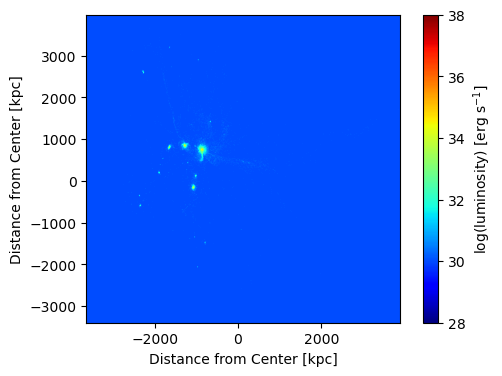

In [45]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_continuum_field_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=28, vmax=38)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [erg s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Stars_Only.png', dpi=500)
# BP Plot luminosity of entire galaxy.

In [46]:
luminosity_total = luminosity_binned + luminosity_continuum_field.value
luminosity_total_log = np.log10(luminosity_total)
luminosity_total_log[luminosity_total_log == -np.inf] = 30

/tmp/ipykernel_636953/1655745931.py:2: RuntimeWarning: divide by zero encountered in log10
  luminosity_total_log = np.log10(luminosity_total)


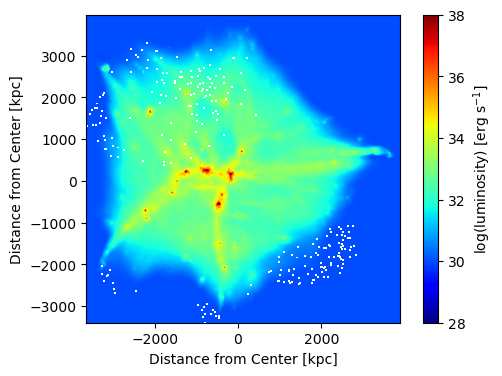

In [47]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_total_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=28, vmax=38)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [erg s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Stars_Only.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convert to photons

In [48]:
luminosity_photon = (luminosity_total * u.erg).to(u.photon, equivalencies=u.spectral_density(ly_alpha_red)) / u.s
luminosity_photon_log = np.log10(luminosity_photon.value)
luminosity_photon_log[luminosity_photon_log == -np.inf] = 40

/tmp/ipykernel_636953/3693938852.py:2: RuntimeWarning: divide by zero encountered in log10
  luminosity_photon_log = np.log10(luminosity_photon.value)


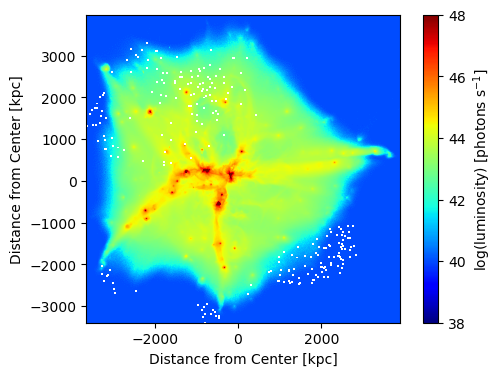

In [49]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_photon_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=38, vmax=48)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [photons s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Gas_Only.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convert to flux at the telescope

In [50]:
galaxy_distance = cosmo.lookback_distance(redshift).to(u.kpc)

In [51]:
mirror_size = 1*u.m
flux = luminosity_photon * mirror_size**2 / (galaxy_distance**2)

In [52]:
flux = flux.to(u.photon / u.s)

In [53]:
exp_time = 2*u.hr

In [54]:
flux_integrated = (flux * exp_time).to(u.photon)

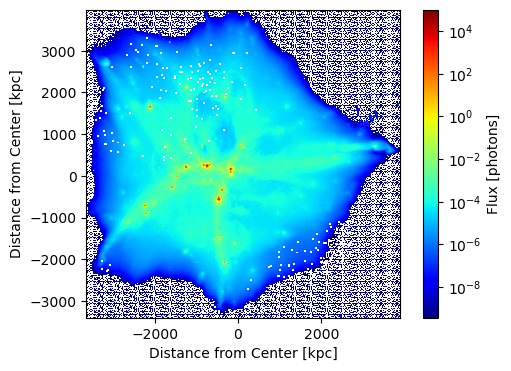

In [55]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_integrated.value, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', norm=LogNorm())
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Flux [photons]')
plt.savefig('Simulated_Flux_Detector.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convert into angular size

In [56]:
arcsec_kpc = cosmo.arcsec_per_kpc_comoving(redshift)

In [57]:
cosmo.kpc_comoving_per_arcmin(redshift) * 20*u.arcmin

<Quantity 15039.75829183 kpc>

In [58]:
x_arcsec = x*u.kpc  * arcsec_kpc
y_arcsec = y*u.kpc * arcsec_kpc

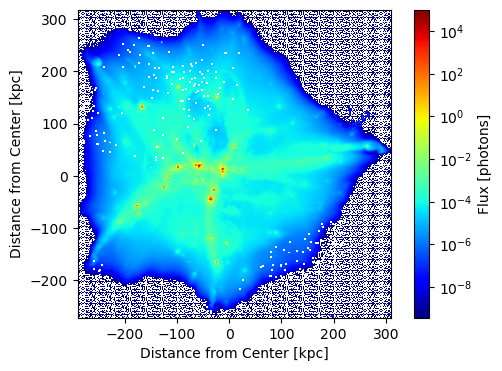

In [59]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_integrated.value, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower', norm=LogNorm())
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Flux [photons]')
plt.savefig('Simulated_Flux_Detector_Arcsec.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convolve with instrument FWHM

In [60]:
arcsec_pp = (x_arcsec.max() - x_arcsec.min()) / n

In [61]:
fwhm = 6*u.arcsecond / arcsec_pp 
# number of pixels to blur by to achieve proper fwhm

In [62]:
kernel = Gaussian2DKernel(x_stddev=fwhm, x_size=2*n, y_size=2*n)

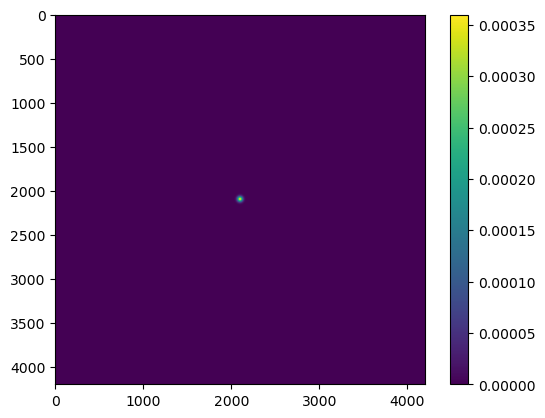

In [63]:
plt.imshow(kernel)
plt.colorbar()

In [64]:
flux_conv = convolve_fft(flux_integrated, kernel)

throughput = 0.024
# Total optical throughput, combines QE, optics throughput, and atmospheric throughput
flux_true = flux_conv * throughput

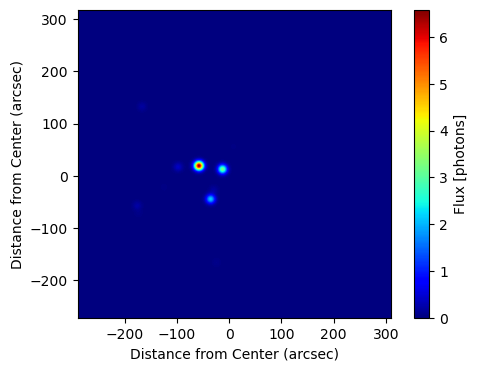

In [65]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_true.value, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower')
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'Flux [photons]')
plt.savefig('Simulated_Observation.png', dpi=500)

### Convert into correct pixel scale

In [66]:
fb_fov = 20 * u.arcmin
fb_pix = 1000

fb_pix_scale = fb_fov / fb_pix

npix = ((x_arcsec.max() - x_arcsec.min()) / fb_pix_scale).si

In [67]:
factor = 4# n/npix
print(factor)
print(n/npix)

4
4.204821330187226


In [68]:
n/4.2

500.0

In [69]:
flux_ccd = block_reduce(flux_true, block_size=(factor, factor), func=np.sum)#, cval=7)

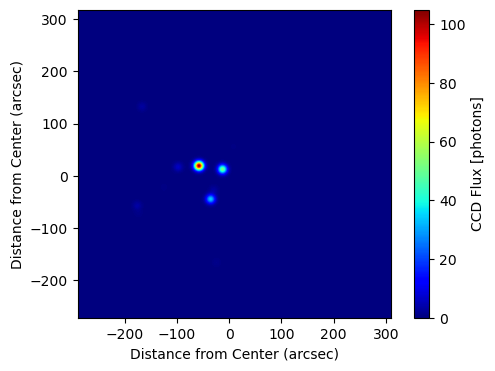

In [70]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_ccd, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower')#, vmin=-40, vmax=-22)
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'CCD Flux [photons]')
plt.savefig('Simulated_Pixel_Scale.png', dpi=500)

## Noise Model

In [71]:
dark_current = (0.036 / u.hour * exp_time).value

In [72]:
cic = 0.002

In [73]:
flux_ccd_noise = flux_ccd + dark_current + cic

### Poisson CCD Noise

In [74]:
signal = np.random.default_rng().poisson(lam=flux_ccd_noise)

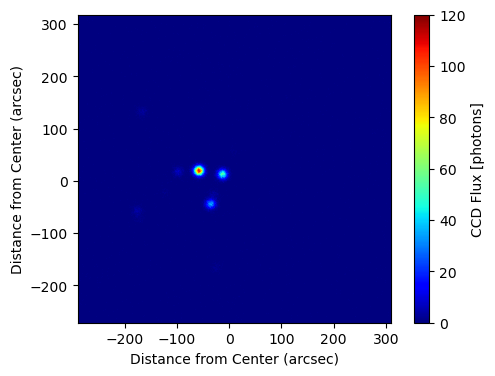

In [75]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(signal, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower')#, vmin=-40, vmax=-22)
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'CCD Flux [photons]')
plt.savefig('Simulated_Flux_Real.png', dpi=500)

In [76]:
noise = np.sqrt(abs(flux_ccd)) + dark_current + cic

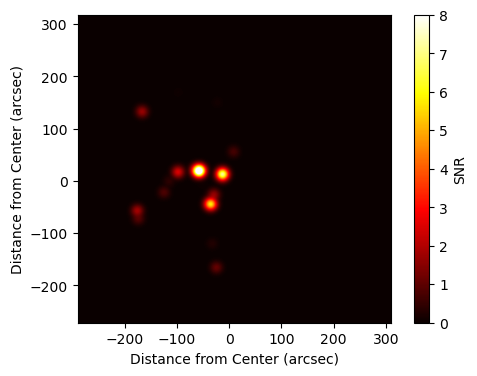

In [77]:
snr = flux_ccd / noise 

fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(snr, cmap = 'hot', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower', vmin=0, vmax=8)
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'SNR')
plt.savefig('Signal_to_Noise_Ratio.png', dpi=500)

# Zoomed In Analysis

In [78]:
x = part['gas']['position'][:, 0]
y = part['gas']['position'][:, 2]
z = part['gas']['position'][:, 1]
# BP Read in gas particle locations

xoffset = 89990.81
yoffset = 89786.91
zoffset = 92491.32
# BP Define center of zoom in region (in kpc).

length = 100
# BP Define side length of zoom in region (in kpc).

ind = (x < xoffset + length) & (x > xoffset - length) & (y < yoffset + length) & (y > yoffset - length)
# BP Calculate indices of all particles within length of xoffset and zoffset.

x = x[ind] - xoffset
y = y[ind] - yoffset
z = z[ind] - zoffset
# BP Renormalize coordinates about the center.

nH = part['gas'].prop('number.density')[ind]
# BP Define hydrogen number density.

mass_frac = part['gas']['massfraction'][:,0][ind]
# BP Get the mass fraction of gas particles.

temp = part['gas']['temperature'][ind]
# BP Get the temperature of gass partiles.

metallicity_fe = part['gas'].prop('metallicity.fe')[ind]
# BP Get the metallicity [Fe/H] of the gas cells.

cell_size = part['gas']['size'][ind] * u.kpc
# BP Get the linear size of each gas cell.

sfr = part['gas']['sfr'][ind]
# BP Get the star formation rate of each gas cell.

# distance = part['gas'].prop('host.distance.total')[ind]
distance = np.sqrt(x**2 + y**2 + z**2)
# BP Get the linear distance of each gas cell to the center of its host galaxy.

gas_loc_plot = np.vstack((x,y)).T
# BP Create grid of coordinates for plotting and interpolating.

In [79]:
star_x = part['star']['position'][:, 0]
star_y = part['star']['position'][:, 2]
star_z = part['star']['position'][:, 1]

star_xoffset = 89990.81
star_yoffset = 89786.91
star_zoffset = 92491.32
# BP Define center of zoom in region (in kpc).

star_ind = (star_x < star_xoffset + length) & (star_x > star_xoffset - length) & (star_y < star_yoffset + length) & (star_y > star_yoffset - length)
# BP Calculate indices of all particles within length of xoffset and zoffset.

star_x = star_x[star_ind] - star_xoffset
star_y = star_y[star_ind] - star_yoffset
star_z = star_z[star_ind] - star_zoffset
# BP Renormalize coordinates about the center.

star_mass = part['star']['mass'][star_ind]

star_age = part['star'].prop('age')[star_ind]

star_loc_plot = np.vstack((star_x, star_y)).T

## Plots

### Generate Phase Diagram

In [80]:
sort = np.argsort(mass_frac)
nH_plot, temp_plot, mass_frac_plot = nH[sort], temp[sort], mass_frac[sort]
# BP Sort markers by mass_frac for plotting.

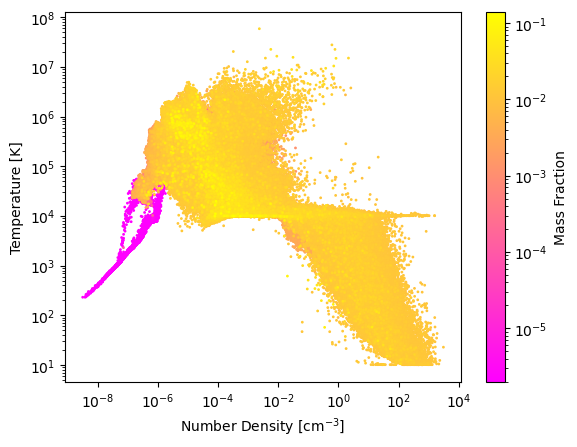

In [81]:
plt.scatter(nH_plot, temp_plot, c=mass_frac_plot, s=1, cmap='spring', norm=LogNorm())
plt.colorbar(label = 'Mass Fraction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number Density [cm$^{{-3}}$]')
plt.ylabel('Temperature [K]')
plt.savefig('Phase_Diagram_Zoom.png', dpi=500)
# BP Plot phase diagram of gas cells.

## Binned Data

### Hydrogen Density

In [82]:
n = 2100
gridx = np.linspace(x.min(), x.max(), n+1)
gridy = np.linspace(y.min(), y.max(), n+1)
# BP Create grid of x and y locations of bin edges with n bins.

In [83]:
nH_sum, _, _ = binned_statistic_dd(gas_loc_plot, nH, bins=[gridx, gridy], statistic='sum')
# BP Calculate total hydrogen density within each bin. 

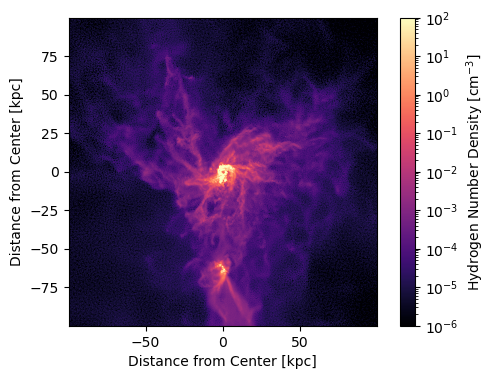

In [84]:
fig, ax = plt.subplots(figsize=(6,4))
plt.imshow(nH_sum, norm = LogNorm(vmin=1e-6, vmax=1e2), cmap = 'magma', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower')#vmin = 1e-8, vmax = 1e-1
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Hydrogen Number Density [cm$^{{-3}}$]')
plt.savefig('Hydrogen_Column_Density_Binned_Zoom.png', dpi=500)
# BP Plot hydrogen density of the center galaxy.

### Temperature

In [85]:
temp_avg, _, _ = binned_statistic_dd(gas_loc_plot, temp, bins=[gridx, gridy], statistic='mean')
temp_avg = np.nan_to_num(temp_avg, nan=0)
# BP Calculate the average gas temperature within each bin.

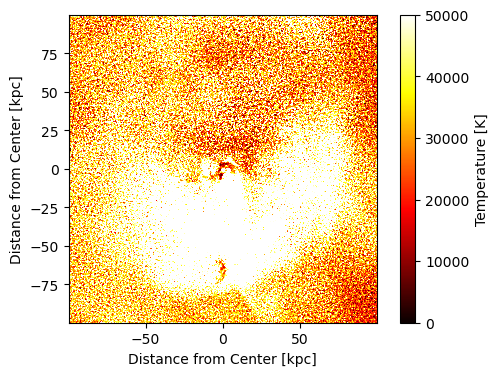

In [86]:
fig, ax = plt.subplots(figsize=(6,4))
plt.imshow(temp_avg, vmin=0, vmax=5e4, cmap = 'hot', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower')
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Temperature [K]')
plt.savefig('Temperature_Binned_Zoom.png', dpi=500)
# BP Plot average temperature for center galaxy.

## Emissivities

### Emissivity from gas

In [87]:
emissivity_log = griddata((grid_dense, grid_temp), grid_lya, (np.log10(nH), np.log10(temp)))
# BP Calculate the emissivity for each gas cell in the zoomed in region.

In [88]:
emissivity_binned, _, _ = binned_statistic_dd(gas_loc_plot, 10**emissivity_log, bins=[gridx, gridy], statistic='sum')
# BP Bin the gas cell emissivity to plot.

In [89]:
emissivity_binned_log = np.log10(emissivity_binned)
emissivity_binned_log[emissivity_binned_log == -np.inf] = -40
# BP Convert to log scale for plotting and replace all infinities.

/tmp/ipykernel_636953/3459541166.py:1: RuntimeWarning: divide by zero encountered in log10
  emissivity_binned_log = np.log10(emissivity_binned)


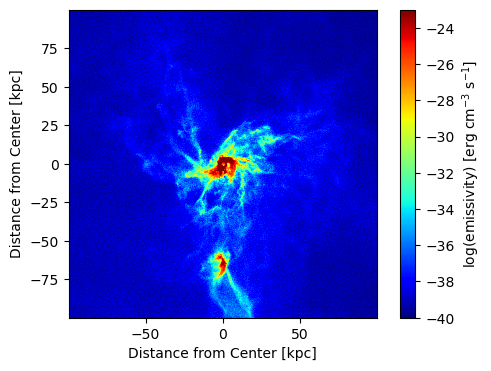

In [90]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(emissivity_binned_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=-40, vmax=-23)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(emissivity) [erg cm$^{{-3}}$ s$^{{-1}}$]')
plt.savefig('Simulated_Emissivity_Gas_Only_Zoom.png', dpi=500)
# BP Plot emissivity for the entire galaxy.

### Convert to luminosity

In [91]:
emissivity_units = 10**emissivity_log * u.erg / u.cm**3 / u.s

In [92]:
cell_size_cube = cell_size**3
# BP Calculate the size of each gas cell.

luminosity_units = (emissivity_units * cell_size_cube).to(u.erg / u.s)
# BP Calculate luminosity assuming square gas cells.

In [93]:
luminosity_binned, _, _ = binned_statistic_dd(gas_loc_plot, luminosity_units, bins=[gridx, gridy], statistic='sum')
luminosity_binned_log = np.log10(luminosity_binned)
luminosity_binned_log[luminosity_binned_log == -np.inf] = 28
# BP Bin the calculated luminosity for plotting as an image.

/tmp/ipykernel_636953/738478506.py:2: RuntimeWarning: divide by zero encountered in log10
  luminosity_binned_log = np.log10(luminosity_binned)


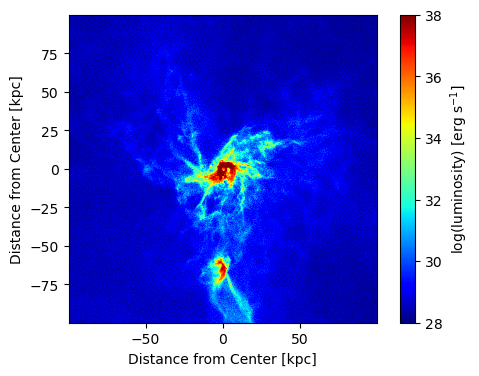

In [94]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_binned_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=28, vmax=38)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [erg s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Gas_Only_Zoom.png', dpi=500)
# BP Plot luminosity of entire galaxy.

In [95]:
total_ly_alpha = np.sum(luminosity_units)
# BP Calculate total Lyman alpha luminosity

print('The total lyman alpha luminosity is {:.3e}'.format(total_ly_alpha))

The total lyman alpha luminosity is 1.945e+42 erg / s


### Lumionsity from stars

In [96]:
ly_alpha = 1215.67 * u.AA
ly_alpha_red = (1 + redshift) * ly_alpha

In [97]:
sfr_tot = np.sum(sfr)
# BP Calculate total star formation rate of galaxy.

In [98]:
luminosity_continuum = (sfr_tot * c.c * 1e28 / (1.4 * ly_alpha_red.to(u.um)**2)).value * u.erg / u.s
# BP Calculate total continuum contribution from stars according to star formation rate.

In [99]:
star_where = star_mass[star_age < 1e8]
# BP Index some stellar property for stars that are younger than 1e8 years.

In [100]:
star_gridx = np.linspace(star_x.min(), star_x.max(), n+1)
star_gridy = np.linspace(star_y.min(), star_y.max(), n+1)
# BP Create grid to interpolate over for stars.

In [101]:
stellar_field, _, _ = binned_statistic_dd(star_loc_plot, star_where, bins=[star_gridx, star_gridy], statistic='count')
stellar_field = stellar_field/np.sum(stellar_field)
# BP Count how many stars are in each bin, normalize to integrate to 1.
# BP This stellar field will be used to scale the continuum luminosity.

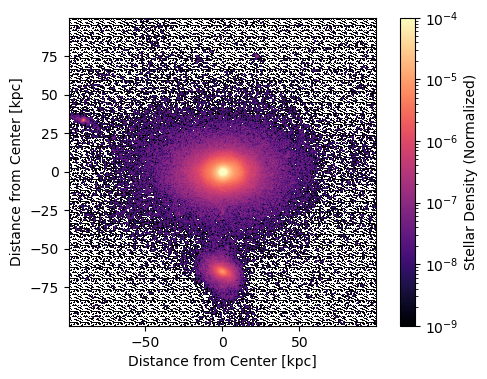

In [102]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(stellar_field, norm=LogNorm(vmin=1e-9, vmax=1e-4), cmap = 'magma', extent = [star_x.min(), star_x.max(), star_y.min(), star_y.max()], origin='lower')
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Stellar Density (Normalized)')
plt.savefig('Stellar_Density_Field_Zoom.png', dpi=500)
# BP Plot stellar field of galaxy.

In [103]:
luminosity_continuum_field = luminosity_continuum * stellar_field

In [104]:
luminosity_continuum_field_log = np.log10(luminosity_continuum_field.value)
luminosity_continuum_field_log[luminosity_continuum_field_log == -np.inf] = 30

/tmp/ipykernel_636953/3314741800.py:1: RuntimeWarning: divide by zero encountered in log10
  luminosity_continuum_field_log = np.log10(luminosity_continuum_field.value)


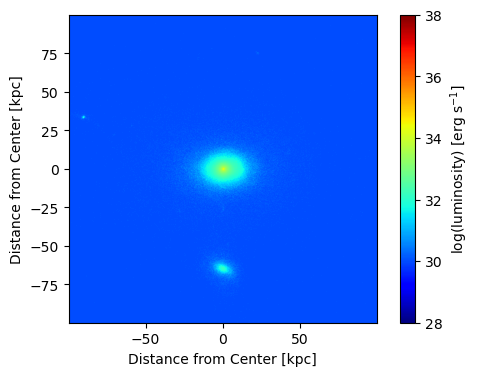

In [105]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_continuum_field_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=28, vmax=38)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [erg s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Stars_Only_Zoom.png', dpi=500)
# BP Plot luminosity of entire galaxy.

In [106]:
luminosity_total = luminosity_binned + luminosity_continuum_field.value
luminosity_total_log = np.log10(luminosity_total)
luminosity_total_log[luminosity_total_log == -np.inf] = 30

/tmp/ipykernel_636953/1655745931.py:2: RuntimeWarning: divide by zero encountered in log10
  luminosity_total_log = np.log10(luminosity_total)


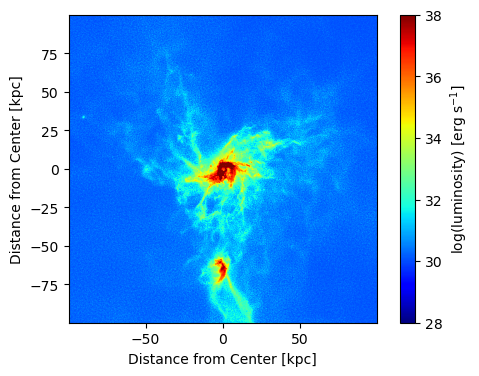

In [107]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_total_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=28, vmax=38)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [erg s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Stars_Only_Zoom.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convert to photons

In [108]:
luminosity_photon = (luminosity_total * u.erg).to(u.photon, equivalencies=u.spectral_density(ly_alpha_red)) / u.s
luminosity_photon_log = np.log10(luminosity_photon.value)
luminosity_photon_log[luminosity_photon_log == -np.inf] = 40

/tmp/ipykernel_636953/3693938852.py:2: RuntimeWarning: divide by zero encountered in log10
  luminosity_photon_log = np.log10(luminosity_photon.value)


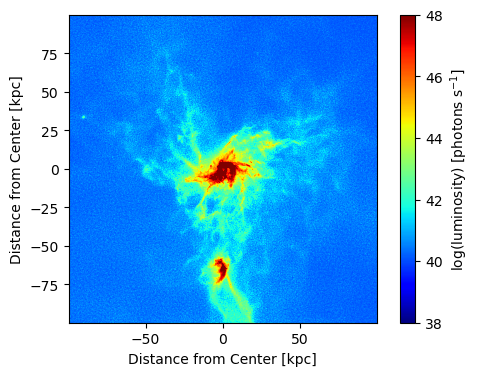

In [109]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(luminosity_photon_log, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', vmin=38, vmax=48)
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'log(luminosity) [photons s$^{{-1}}$]')
plt.savefig('Simulated_Luminosity_Gas_Only_Zoom.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convert to flux at the telescope

In [110]:
galaxy_distance = cosmo.lookback_distance(redshift).to(u.kpc)

In [111]:
mirror_size = 1*u.m
flux = luminosity_photon * mirror_size**2 / (galaxy_distance**2)

In [112]:
flux = flux.to(u.photon / u.s)

In [113]:
exp_time = 2*u.hr

In [114]:
flux_integrated = (flux * exp_time).to(u.photon)

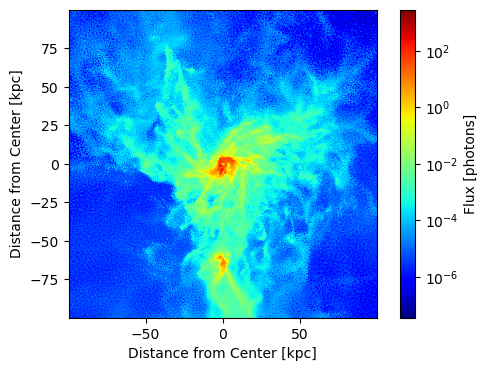

In [115]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_integrated.value, cmap = 'jet', extent = [x.min(), x.max(), y.min(), y.max()], origin='lower', norm=LogNorm())
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Flux [photons]')
plt.savefig('Simulated_Flux_Detector_Zoom.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convert into angular size

In [116]:
arcsec_kpc = cosmo.arcsec_per_kpc_comoving(redshift)

In [117]:
cosmo.kpc_comoving_per_arcmin(redshift) * 20*u.arcmin

<Quantity 15039.75829183 kpc>

In [118]:
x_arcsec = x*u.kpc  * arcsec_kpc
y_arcsec = y*u.kpc * arcsec_kpc

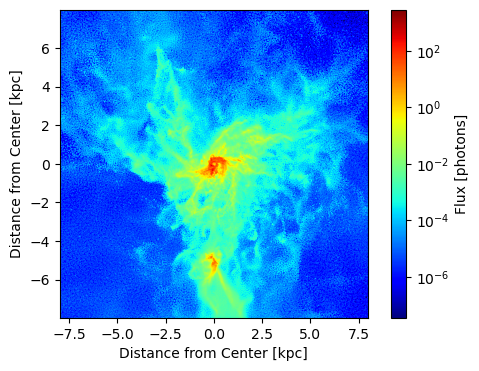

In [119]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_integrated.value, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower', norm=LogNorm())
plt.xlabel('Distance from Center [kpc]')
plt.ylabel('Distance from Center [kpc]')
plt.colorbar(label = r'Flux [photons]')
plt.savefig('Simulated_Flux_Detector_Arcsec_Zoom.png', dpi=500)
# BP Plot luminosity of entire galaxy.

### Convolve with instrument FWHM

In [120]:
arcsec_pp = (x_arcsec.max() - x_arcsec.min()) / n

In [121]:
fwhm = 6*u.arcsecond / arcsec_pp 
# number of pixels to blur by to achieve proper fwhm

In [122]:
kernel = Gaussian2DKernel(x_stddev=fwhm, x_size=2*n, y_size=2*n)

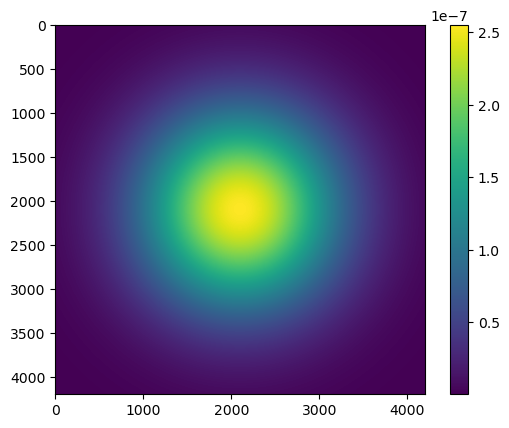

In [123]:
plt.imshow(kernel)
plt.colorbar()

In [124]:
flux_conv = convolve_fft(flux_integrated, kernel)

throughput = 0.024
# Total optical throughput, combines QE, optics throughput, and atmospheric throughput
flux_true = flux_conv * throughput

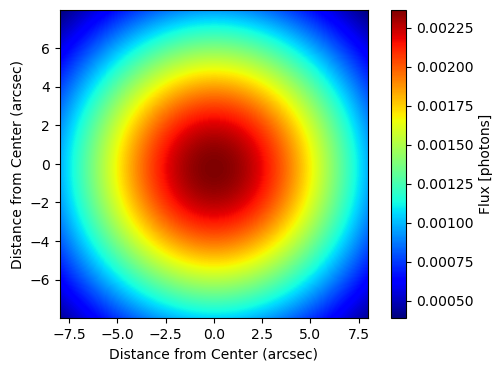

In [125]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_true.value, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower')
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'Flux [photons]')
plt.savefig('Simulated_Observation_Zoom.png', dpi=500)

### Convert into correct pixel scale

In [126]:
fb_fov = 20 * u.arcmin
fb_pix = 1000

fb_pix_scale = fb_fov / fb_pix

npix = ((x_arcsec.max() - x_arcsec.min()) / fb_pix_scale).si

In [139]:
factor = 150# n/npix
print(factor)
print(n/npix)

150
157.91770514607813


In [140]:
n/150

14.0

In [141]:
flux_ccd = block_reduce(flux_true, block_size=(factor, factor), func=np.sum)#, cval=7)

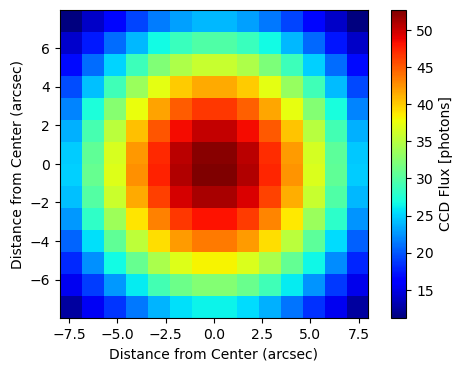

In [142]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(flux_ccd, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower')#, vmin=-40, vmax=-22)
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'CCD Flux [photons]')
plt.savefig('Simulated_Pixel_Scale_Zoom.png', dpi=500)

## Noise Model

In [143]:
dark_current = (0.036 / u.hour * exp_time).value

In [144]:
cic = 0.002

In [145]:
flux_ccd_noise = flux_ccd + dark_current + cic

### Poisson CCD Noise

In [146]:
signal = np.random.default_rng().poisson(lam=flux_ccd_noise)

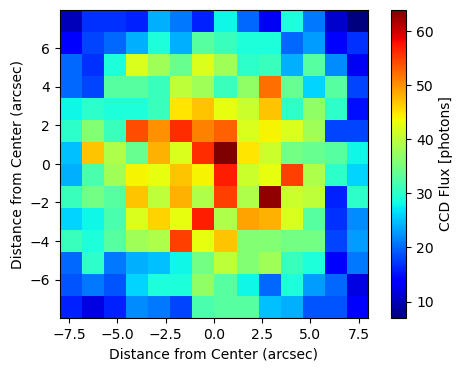

In [147]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(signal, cmap = 'jet', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower')#, vmin=-40, vmax=-22)
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'CCD Flux [photons]')
plt.savefig('Simulated_Flux_Real_Zoom.png', dpi=500)

In [148]:
noise = np.sqrt(abs(flux_ccd)) + dark_current + cic

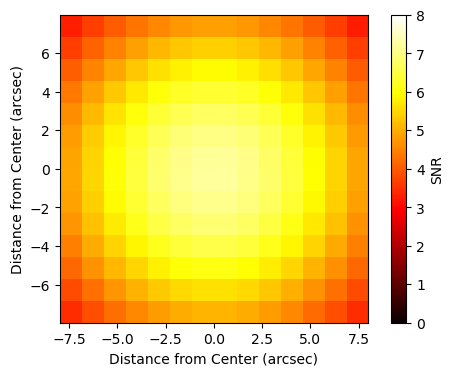

In [149]:
snr = flux_ccd / noise 

fig, ax = plt.subplots(figsize = (6, 4))
plt.imshow(snr, cmap = 'hot', extent = [x_arcsec.min(), x_arcsec.max(), y_arcsec.min(), y_arcsec.max()], origin='lower', vmin=0, vmax=8)
plt.xlabel('Distance from Center (arcsec)')
plt.ylabel('Distance from Center (arcsec)')
plt.colorbar(label = r'SNR')
plt.savefig('Signal_to_Noise_Ratio_Zoom.png', dpi=500)